<a href="https://colab.research.google.com/github/ashtonsouthwick/DSPS_ASouthwick/blob/main/HW8/SouthwickhiggsbosonSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#imports

In [2]:
#mount your google drive
from google.colab import drive
drive.mount('/content/drive')
import json
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from pprint import pprint
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, mean_absolute_error, mean_squared_error
from mpl_toolkits.axes_grid1 import make_axes_locatable #I googled where to import this function from, the google AI overview gave me this import
from sklearn.metrics import roc_curve
from sklearn.model_selection import RandomizedSearchCV

Mounted at /content/drive


## Remember tasks are not completed if you do not comment on the results and include captions

# Task 1 : data ingestion

- Download the Higgs boson data from Kaggle (programmatically within the notebook)

see how I did it in the Titanic Trees notebook https://github.com/fedhere/DSPS_FBianco/blob/main/CodeDemos/titanictree.ipynb

find the correct API link here https://www.kaggle.com/c/higgs-boson/data. The command is `!kaggle competitions download......` (you may need to agree to the terms of condition of the higgs boson challenge on the kaggle webpage)


In [3]:
%cd drive/My\ Drive/

/content/drive/My Drive


In [4]:
ls kaggle.json

kaggle.json


In [5]:
!chmod 600 kaggle.json

In [6]:
ls kaggle.json

kaggle.json


In [7]:
envs = json.load(open("kaggle.json", "r"))
os.environ["KAGGLE_USERNAME"] = envs['username']
os.environ["KAGGLE_KEY"] = envs['key']

In [8]:
cd dsps

/content/drive/My Drive/dsps


In [9]:
# i suggest you put the data in a folder inside of your dsps folder, which you shoudl already have
!mkdir higgsboson


mkdir: cannot create directory ‘higgsboson’: File exists


In [10]:
cd higgsboson

/content/drive/My Drive/dsps/higgsboson


In [11]:
!kaggle competitions download -c higgs-boson

higgs-boson.zip: Skipping, found more recently modified local copy (use --force to force download)


In [12]:
# !unzip higgs-boson.zip

In [13]:
ls

HiggsBosonCompetition_AMSMetric_rev1.py  random_submission.zip  training.csv
higgs-boson.zip                          test.csv               training.zip
random_submission.csv                    test.zip


In [14]:
# !unzip '*.zip'

In [15]:
ls

HiggsBosonCompetition_AMSMetric_rev1.py  random_submission.zip  training.csv
higgs-boson.zip                          test.csv               training.zip
random_submission.csv                    test.zip


In [16]:
#use the training dataset and make your own trainng test set later
higgsdata = pd.read_csv("training.csv")

# Task 2: data exploration

In [17]:
higgsdata.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


In [18]:
higgsdata.describe()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,224999.500000,-49.023079,49.239819,81.181982,57.895962,-708.420675,-601.237051,-709.356603,2.373100,18.917332,...,209.797178,0.979176,-348.329567,-399.254314,-399.259788,-692.381204,-709.121609,-709.118631,73.064591,1.646767
std,72168.927986,406.345647,35.344886,40.828691,63.655682,454.480565,657.972302,453.019877,0.782911,22.273494,...,126.499506,0.977426,532.962789,489.338286,489.333883,479.875496,453.384624,453.389017,98.015662,1.875103
min,100000.000000,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,0.000000,...,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.001502
25%,162499.750000,78.100750,19.241000,59.388750,14.068750,-999.000000,-999.000000,-999.000000,1.810000,2.841000,...,123.017500,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-0.000000,0.018636
50%,224999.500000,105.012000,46.524000,73.752000,38.467500,-999.000000,-999.000000,-999.000000,2.491500,12.315500,...,179.739000,1.000000,38.960000,-1.872000,-2.093000,-999.000000,-999.000000,-999.000000,40.512500,1.156188
75%,287499.250000,130.606250,73.598000,92.259000,79.169000,0.490000,83.446000,-4.593000,2.961000,27.591000,...,263.379250,2.000000,75.349000,0.433000,0.503000,33.703000,-2.457000,-2.275000,109.933750,2.404128
max,349999.000000,1192.026000,690.075000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,2834.999000,...,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000,7.822543


do everything else you need to explore the data.... (I can think of 4 more things we have done together)

In [19]:
higgsdata.shape

(250000, 33)

In [20]:
higgsdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   EventId                      250000 non-null  int64  
 1   DER_mass_MMC                 250000 non-null  float64
 2   DER_mass_transverse_met_lep  250000 non-null  float64
 3   DER_mass_vis                 250000 non-null  float64
 4   DER_pt_h                     250000 non-null  float64
 5   DER_deltaeta_jet_jet         250000 non-null  float64
 6   DER_mass_jet_jet             250000 non-null  float64
 7   DER_prodeta_jet_jet          250000 non-null  float64
 8   DER_deltar_tau_lep           250000 non-null  float64
 9   DER_pt_tot                   250000 non-null  float64
 10  DER_sum_pt                   250000 non-null  float64
 11  DER_pt_ratio_lep_tau         250000 non-null  float64
 12  DER_met_phi_centrality       250000 non-null  float64
 13 

In [21]:
higgsdata.columns

Index(['EventId', 'DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt',
       'Weight', 'Label'],
      dtype='object')

In [22]:
higgsdata.tail(3)

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
249997,349997,105.457,60.526,75.839,39.757,-999.0,-999.0,-999.0,2.390,22.183,...,1,41.992,1.8,-0.166,-999.0,-999.0,-999.0,41.992,0.018636,s
249998,349998,94.951,19.362,68.812,13.504,-999.0,-999.0,-999.0,3.365,13.504,...,0,-999.000,-999.0,-999.000,-999.0,-999.0,-999.0,0.000,1.681611,b
249999,349999,-999.000,72.756,70.831,7.479,-999.0,-999.0,-999.0,2.025,7.479,...,0,-999.000,-999.0,-999.000,-999.0,-999.0,-999.0,0.000,1.877474,b


In [23]:
higgsdata.dtypes

,0
EventId,int64
DER_mass_MMC,float64
DER_mass_transverse_met_lep,float64
DER_mass_vis,float64
DER_pt_h,float64
DER_deltaeta_jet_jet,float64
DER_mass_jet_jet,float64
DER_prodeta_jet_jet,float64
DER_deltar_tau_lep,float64
DER_pt_tot,float64


# Task 3: data preparation


- Read in the trainind data. Extract the target variables. Split the provided training data into a training and a test set.

The last 2 columns are what you want to predict: "weight" and "label".
Remove them from the input data (along any other variable you should remove) and create a separate variable `labels` and a separate variable `weights`, which will be your target variables for, respectively, classification and regression.



 you will use two target variables (you can read more about the data at https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf): find the corresponding columns of the DF and save them as labels and weights respectively

In [24]:
labels = np.array(higgsdata['Label'])
weights = np.array(higgsdata['Weight'])

In [25]:
labels # 's' stands for signal, 'b' for background. You want to find new particles, i.e. "signal"

array(['s', 'b', 'b', ..., 's', 'b', 'b'], dtype=object)

In [26]:
weights # the weight of the particle

array([0.00265331, 2.23358449, 2.34738894, ..., 0.01863612, 1.68161144,
       1.87747381])

use the "training.csv" file, but create your own train/test sets

In [27]:
features = higgsdata.drop(columns=['Weight', 'Label', 'EventId'])

In [28]:
train_x, test_x, train_y, test_y = train_test_split(features, higgsdata['Label'],
                                                    train_size=0.75, shuffle=True, random_state=67)
train_x.shape, train_y.shape, test_x.shape, test_y.shape
#categorical: signal or background

((187500, 30), (187500,), (62500, 30), (62500,))

In [29]:
train_regress_x, test_regress_x, train_regress_y, test_regress_y = train_test_split(features, higgsdata['Weight'],
                                                    train_size=0.75, shuffle=True, random_state=67)
train_regress_x.shape, train_regress_y.shape, test_regress_x.shape, test_regress_y.shape
#continuous : event weight

((187500, 30), (187500,), (62500, 30), (62500,))

#Task 4: answer the question (you, not an AI...) why did I not ask you to scale the data like we did in the cluster models?

Because clustering relies on distances, whereas trees don't but rather rely on features of the data, so scaling wouldn't change anything while working with trees. You only look at one variable at a time, so how the parameters relate to each other does not really matter. The distance between points does not matter.

# Task 5: tree-based classifications

Use a Random Forest and a Gradiend Boosted Tree Classifier model to predict the `label` of the particles, i.e. if a particle is `Signal` or `Background`. Get the score of each model on both the training and test set, compare them training and test results and comment on the result for each model (adjust the hyperparameters if you need to)


In [30]:
# Look at parameters used by our current forest
rf = RandomForestClassifier(random_state = 0)
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


In [31]:
#now control some hyperparameters
rf = RandomForestClassifier(max_depth=6,criterion='gini', random_state=67).fit(train_x,train_y)

In [32]:
# for depth in [1,2,3,4,5,6]:
#   rf = RandomForestClassifier(max_depth=depth,criterion='gini', random_state=67).fit(train_x,train_y)
#   print(f"training accuracy {rf.score(train_x,  train_y):.2f}, testing accuracy {rf.score(test_x,  test_y):.2f}")

For the sake of time, I'll paste the results of the code above so I don't have to keep running it

training accuracy 0.68, testing accuracy 0.68

training accuracy 0.74, testing accuracy 0.75

training accuracy 0.79, testing accuracy 0.79

training accuracy 0.81, testing accuracy 0.81

training accuracy 0.82, testing accuracy 0.82

training accuracy 0.82, testing accuracy 0.82


So it is starting to plateau at depth=6, therefore I think it is safe to assume to use max_depth=6

In [33]:
# print(f"training accuracy {rf.score(train_x,  train_y):.2f}, testing accuracy {rf.score(test_x,  test_y):.2f}")

In [34]:
gbt = GradientBoostingClassifier(max_depth=6, random_state=67).fit(train_x,train_y)

In [35]:
# for depth in [1,2,3,4,5,6]:
#   gbt = GradientBoostingClassifier(max_depth=depth, random_state=67).fit(train_x,train_y)
#   print(f"training accuracy {gbt.score(train_x,  train_y):.2f}, testing accuracy {gbt.score(test_x,  test_y):.2f}")

For the sake of time again, I'll paste the results of the code above so I dont have to keep running it:

training accuracy 0.81, testing accuracy 0.81

training accuracy 0.82, testing accuracy 0.82

training accuracy 0.83, testing accuracy 0.83

training accuracy 0.84, testing accuracy 0.83

training accuracy 0.85, testing accuracy 0.84

training accuracy 0.85, testing accuracy 0.84

So it is starting to plateau at depth=6, therefore I think it is safe to assume to use max_depth=6

Both the random forest and gradient boosting classifier models perform well, but the gradient boosting classifier has the slight edge for this case, with accuracies of about 0.85, whereas the random forest has accuracies of about 0.82.

# Task 6: model evaluation

calculate the  scores for the training and test sets and compare etc

In [36]:
print(f"the RF scores on the training test is {rf.score(train_x,  train_y):.2f}, on the test is {rf.score(test_x,  test_y):.3f}")
print("this indicates good model performance. both the training and test scores are relatively high and similar.")
print(f"the GBT scores on the training test is {gbt.score(train_x,  train_y):.2f}, on the test is {gbt.score(test_x,  test_y):.3f}")
print("this indicates slightly better model performance than the random forest."
"both the training and test scores and relatively high and similar.")


the RF scores on the training test is 0.82, on the test is 0.819
this indicates good model performance. both the training and test scores are relatively high and similar.
the GBT scores on the training test is 0.85, on the test is 0.839
this indicates slightly better model performance than the random forest.both the training and test scores and relatively high and similar.


**Comment** is your model performing well? is it .... overfitting?

Neither models are overfitting, as they have high and extremely similar scores (approximately equal)

- Produce a confusion matrix for each model and compare them






In [37]:
# I creaded this function (mostly copied from sklearn examples).
# You can use it to create the confusion matrix, make sure you pass appropriate label

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title='', labels=["P", "N"],
                          cmap=plt.cm.bone):
    """
    Plots a confusion matrix.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        normalize (bool, optional): If True, normalize the confusion matrix. Defaults to False.
        title (str, optional): Title of the plot. Defaults to ''.
        labels (list, optional): List of labels for the classes. Defaults to ["P", "N"].
        cmap (matplotlib.colors.Colormap, optional): Colormap for the plot. Defaults to plt.cm.bone.
    """
    if normalize:
          title = title + ' Normalized confusion matrix'
    else:
          title = title + ' Confusion matrix, without normalization'
    # Compute confusion matrix
    if normalize:
      cm = confusion_matrix(y_true, y_pred, normalize='all')
    else:
      cm = confusion_matrix(y_true, y_pred)
    # plot it
    fig, ax = plt.subplots(1, 1)
    fig.subplots_adjust()
    im = ax.imshow(np.rot90(cm), cmap=cmap)
    ax_divider = make_axes_locatable(ax)
    # add an axes to the right of the main axes.
    plt.xticks([0, 1], labels=labels[::-1])

    plt.text(0,1, cm[0,0], ha='center', c="k" if cm[0,0] > 0.1 * cm.sum() else "w")
    plt.text(0,0, cm[0,1], ha='center', c="k" if cm[0,1] > 0.1 * cm.sum() else "w")
    plt.text(1,1, cm[1,0], ha='center', c="k" if cm[1,0] > 0.1 * cm.sum() else "w")
    plt.text(1,0, cm[1,1], ha='center', c="k" if cm[1,1] > 0.1 * cm.sum() else "w")
    plt.ylim(-0.5,1.5)
    plt.yticks([0,1], labels=labels)
    plt.xlabel("prediction")
    plt.ylabel("truth")
    plt.title(title)
    cax = ax_divider.append_axes("right", size="10%", pad="2%")
    cb = plt.colorbar(im, cax=cax)

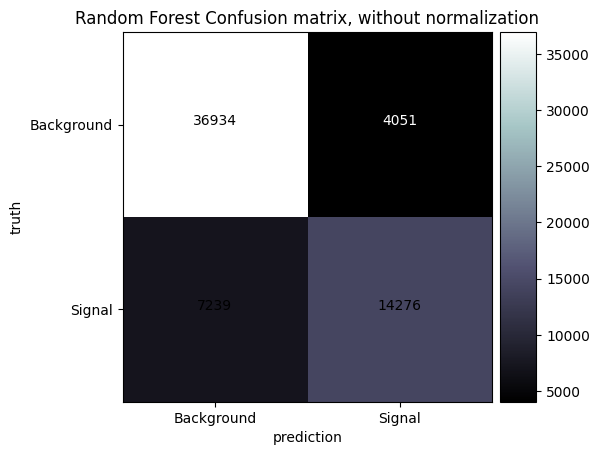

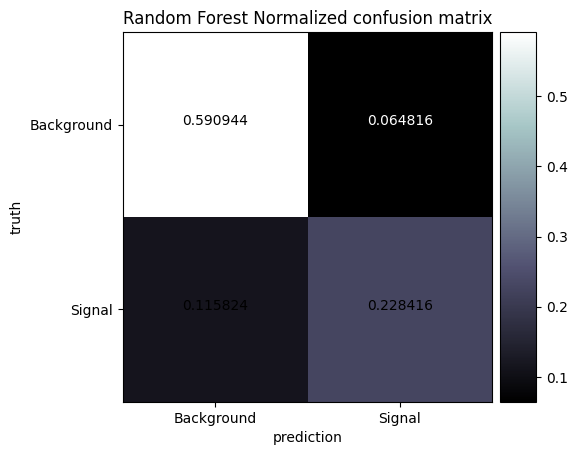

In [38]:
#for RF
plot_confusion_matrix(rf.predict(test_x), test_y, normalize=False, title='Random Forest', labels=['Signal', 'Background'])
plot_confusion_matrix(rf.predict(test_x), test_y, normalize=True, title="Random Forest", labels=['Signal', 'Background'])

**CAPTIONS**

Top Plot: This plot shows the raw number of predictions made from the Random Forest. This model correctly finds most background events effectively (36934), and correctly finds less signal events (14276). There are a small number of misclassifications as seen on the top right and bottom left squares, with 7239 signal events detected as background events, and 4051 background events detected as signal events.

Bottom Plot: The same plot but normalized. This shows the percentage of true negatives (about 59% of backgrounds detected as backgrounds) and true positives (about 22.8% signal events detected as signals), and smaller percentages of false positives and negatives (about 11.58% of signal events were detected as backgrounds, and about 6.5% background events detected as signals). This shows that the model does a good job at finding background events, at about 60% success, and does a good job at not misclassifying backgrounds as signals.

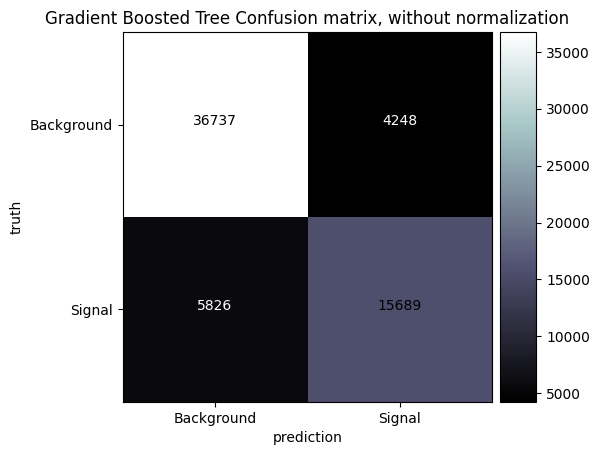

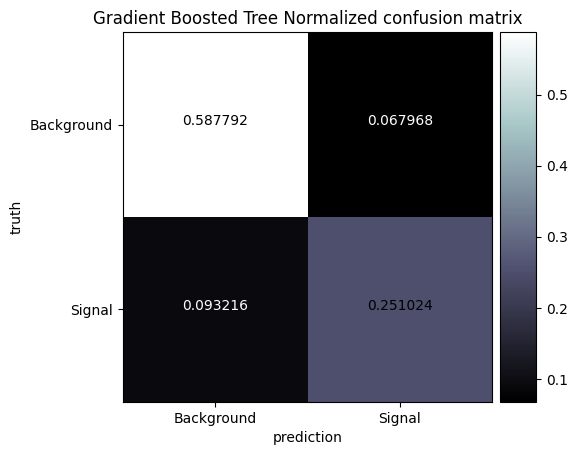

In [39]:
#do the same fo GBT, dont forget your captions!!
plot_confusion_matrix(gbt.predict(test_x), test_y, normalize=False, title='Gradient Boosted Tree', labels=['Signal', 'Background'])
plot_confusion_matrix(gbt.predict(test_x), test_y, normalize=True, title="Gradient Boosted Tree", labels=['Signal', 'Background'])

**CAPTIONS**

Top Plot: This plot shows the raw number of predictions made from the Gradient Boosted Tree. This model correctly finds most background events effectively (36737), and correctly finds less signal events (15689). There are a small number of misclassifications as seen on the top right and bottom left squares, with 5826 signal events detected as background events, and 4248 background events detected as signal events. This model performs roughly equally to the random forest at finding true background events, but does slightly better at finding true signals, and therefore finding less false positives and negatives.

Bottom Plot: The same plot but normalized. This shows the percentage of true negatives (about 58.7% of backgrounds detected as backgrounds) and true positives (about 25.1% signal events detected as signals), and smaller percentages of false positives and negatives (about 9.3% of signal events were detected as backgrounds, and about 6.8% background events detected as signals). This shows that the model does a good job at finding background events, at about 58.7% success, and does a better job than the random forest at not misclassifying backgrounds as signals.

 Although this model performs slightly worse at finding true background events, and finds slightly more false signals, it performs much better at finding true signals than the random forest, indicating it is a slightly better model than the random forest in this scenario.

Plot a simple ROC curve for the RF and GBT models  a d describe it in a caption.

In [40]:
#this will be passed to the ROC function
test_y_array = np.array(test_y) #make array so can use .reshape
test_y_array.reshape(-1, 1).flatten() == "s"

array([False,  True, False, ..., False, False,  True])

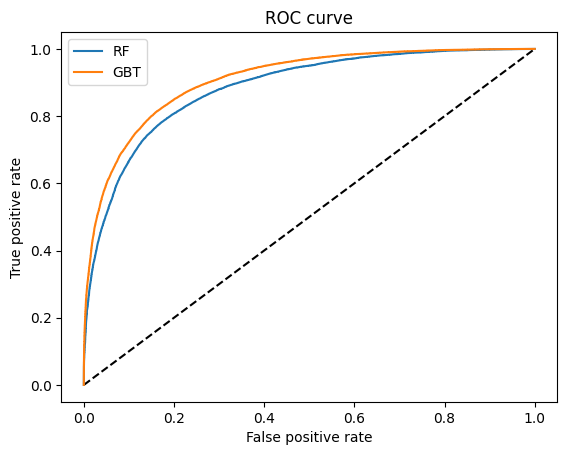

In [41]:
# The random forest model by itself
y_pred_grd_rfcat = rf.predict_proba(test_x)[:, 1]
y_pred_grd_gbtcat = gbt.predict_proba(test_x)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(test_y_array.reshape(-1, 1).flatten()=="s", y_pred_grd_rfcat)
fpr_gbt, tpr_gbt, _ = roc_curve(test_y_array.reshape(-1, 1).flatten()=="s", y_pred_grd_gbtcat)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_gbt, tpr_gbt, label='GBT')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


## CAPTION ##

This ROC plot shows the comparison of the performance of the two models: random forest, and gradient boosting tree and their efficiency of distuingishing background and signal events. Ideally in an ROC plot, you want your model to be in the top left, because that means it maximizes it's true positive rate while minimizing its false positive rate. From this, we can see that the GBT model has slightly stronger performance than the random forest. This agrees with the outcome of the confusion matrices.

#Task 7 required for 661, EC for 461, tree-based regression


- Use a Random Forest and a Gradiend Boosted Tree Regressor model to predict the weight of the particles. Compare the model performance on training and test sets


In [42]:
rfR = RandomForestRegressor(max_depth=3, random_state=302)
rfR.fit(train_regress_x, train_regress_y)
gbtR = GradientBoostingRegressor(max_depth=3, random_state=302)
gbtR.fit(train_regress_x, train_regress_y)

GradientBoostingRegressor(random_state=302)

 Calculate the L2 and L1 loss functions for the fitted regression models (see slides for the definition) and discuss the results

In [43]:
def L1(y_test, y_pred):
  return mean_absolute_error(y_test, y_pred)
def L2(y_test, y_pred):
  return mean_squared_error(y_test, y_pred)

In [44]:

print(f"L1 RF {L1(test_regress_y,  rfR.predict(test_regress_x)):.2f}, L2 RF {L2(test_regress_y, rfR.predict(test_regress_x)):.2f}")

L1 RF 1.01, L2 RF 1.85


In [45]:
print(f"L1 GBT {L1(test_regress_y,  gbtR.predict(test_regress_x)):.2f}, L2 GBT {L2(test_regress_y, gbtR.predict(test_regress_x)):.2f}")

L1 GBT 0.85, L2 GBT 1.37


The L2 functions typically have larger values because they square the differences, so larger differences will lead to even larger L2 values since they are squared. The GBT has lower loss function values than the RF, meaning GBT overall performs better than the RF, which is consistent with the confusion matrices and ROC plot.

**Discuss!**

#Task 8: Choose between feature importance and grid optimization (due for both 461 and 661)







# Task 8a: feature importance
Use the "Titanic notebook" as a guide for the feature importance analysis  https://github.com/fedhere/DSPS_FBianco/blob/main/Labs/DSPS_2025_titanictree.ipynb

- For the Random Forest classifier, find the 4 most important features based on the simple unoptimized model you created earlier on. Use the documentation to find out what they are. We have not talked abotu the physics of this problem at all but the Kaggle challenge description should provide enogh information for you to comment on this result is somewhat superficially.

You can use ```rf.feature_importance_``` on the trained model to extract the relative importance of each feature (a number from 0 to 1) and then choose the features that have the 4 highest numbers (the numpy function ```argsort()``` is helpful here!)

(your features may looks slightly different than mine)

In [46]:
importances = rf.feature_importances_

In [47]:
best_features_index = np.argsort(importances[-4:]) # 4 most important

In [48]:
feature_names = higgsdata.drop(["EventId", "Label", "Weight"], axis=1).iloc[:, best_features_index[::-1]] #this sorts the data by feature

In [49]:
for i in feature_names:
  print(i)

DER_pt_h
DER_mass_MMC
DER_mass_transverse_met_lep
DER_mass_vis


Text(0.5, 0, 'Features')

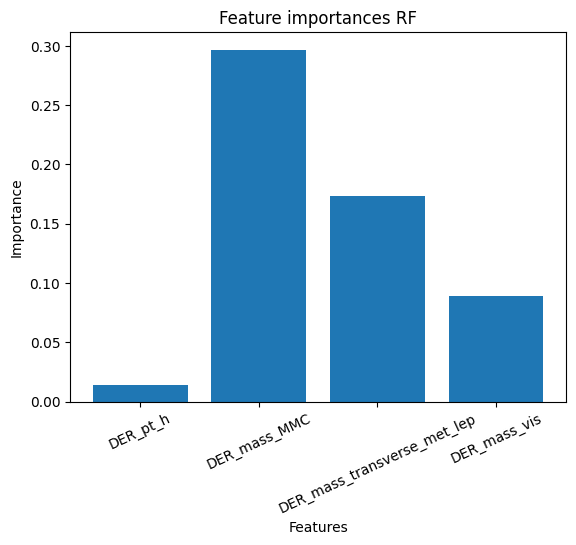

In [50]:
plt.figure()
plt.title("Feature importances RF")
plt.bar(range(feature_names.shape[1]), importances[best_features_index[::-1]])
plt.xticks(range(feature_names.shape[1]), feature_names.columns, rotation=25)
plt.ylabel("Importance")
plt.xlabel("Features")

## CAPTION ##
The four most important features when it comes to computing a random forest on the higgs dataset. The DER prefixes stand for derived, as they are quantities computed from the primitive features. The DER_mass_MMC feature is the most important. This feature is the mass of the higgs target, which is definitely a huge indicator of whether or not your particle is a higgs boson. The DER_mass_transverse_met_lep feature is the second most important. This represents the transverse mass of the target. The third most important feature is the DER_mass_vis feature, which is the visible mass of the system. The fourth most important is the DER_pt_h feature, which represents the momentum of the target particle. The mass is a defining property of the higgs boson, so it makes sense that these mass related features are important in figuring out if your target is a higgs boson or not.

(I had ChatGPT help me figure out what these features are, and I also clarified on the kaggle website)

# Task 8b: hyperparameters grid search
- Explore the parameter space with the sklearn module ```sklearn.model_selection.RandomizedSearchCV``` *fitting only those 4 features*

Follow this example to set up the parameter search. Set the estimators to 10 and 100, (the number of trees) and the max depth to 3, and 10, and None (let it be unconstrained). Set bootstrap to both True and False. Set the number of features to consider at every split to both "autp" and "sqrt". Use ```pprint``` like I did earlier in this notebook to print the parameters set

**this takes some computational time! so do not start this at the last minute!!**

In [61]:
# choose your preferred values for the parameters you will test
random_grid = {'n_estimators': [10, 100],
               'max_depth': [3, 10, None],
               'bootstrap': [True, False],
               'max_features': [None, "sqrt"]}

The colab ai autofilled the random grid for me, which was nice

In [62]:
pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [3, 10, None],
 'max_features': [None, 'sqrt'],
 'n_estimators': [10, 100]}


 mine and your best features do not necessarily have to be the same because our models may be different (different parameters, different random seed etc)

In [63]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# Random search of parameters, using 3 fold cross validation,
# search across 18 different combinations
random_search = RandomizedSearchCV(estimator = rf, param_distributions=random_grid,
                                   n_iter=1, cv=3, error_score='raise')


Note that this may take a long time! It took 1 hour for me to run this. Dont start at the last minute!!

In [64]:
random_search.fit(train_x[::5], train_y[::5])
# subselecting every 5th observation to reduce the computational time

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=RandomForestClassifier(max_depth=6,
                                                    random_state=67),
                   n_iter=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 10, None],
                                        'max_features': [None, 'sqrt'],
                                        'n_estimators': [10, 100]})

In [65]:
random_search.best_estimator_

RandomForestClassifier(random_state=67)

In [66]:
for k in random_search.best_params_:
  print(k,random_search.best_params_[k])

n_estimators 100
max_features sqrt
max_depth None
bootstrap True


In [67]:
rf = RandomForestClassifier(**random_search.best_params_)
pprint(rf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [68]:
rf.fit(train_x, train_y)

RandomForestClassifier()

In [69]:
print("Tuned RF  Parameters: {}".format(random_search.best_params_))
print("Best score is {}".format(rf.score(test_x, test_y)))


Tuned RF  Parameters: {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
Best score is 0.836224


In [70]:
df = pd.DataFrame(random_search.cv_results_) # this shows the result for the given parameters
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,20.931983,2.504305,0.351862,0.048488,100,sqrt,None,True,"{'n_estimators': 100, 'max_features': 'sqrt', ...",0.83112,0.83376,0.84024,0.83504,0.003832,1


Plot a simple  ROC curve for the RF model with the best parameters found in the previous step. Describe it. Compare it with the GBT model from before

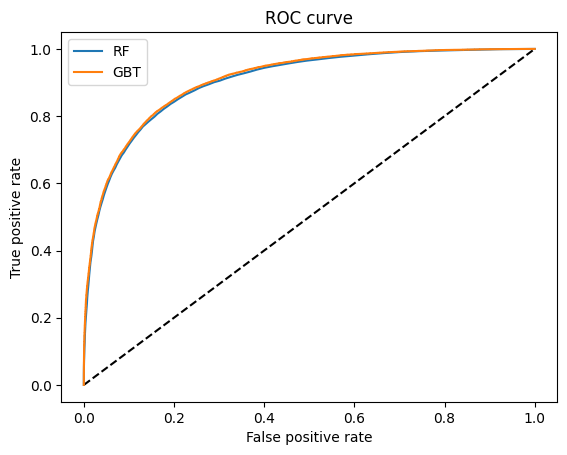

In [72]:
# The random forest model by itself
y_pred_grd_rfcat = rf.predict_proba(test_x)[:, 1]
y_pred_grd_gbtcat = gbt.predict_proba(test_x)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(test_y_array.reshape(-1, 1).flatten()=="s", y_pred_grd_rfcat)
fpr_gbt, tpr_gbt, _ = roc_curve(test_y_array.reshape(-1, 1).flatten()=="s", y_pred_grd_gbtcat)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_gbt, tpr_gbt, label='GBT')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## CAPTION ##

This plot shows the ROC curves for the random forest and gradient boosted tree models. Both models show very strong performance, as they both have curves that stay above the diagnal line. This shows high true positive rates while maintaining low false positives. Note that you can see that GBT is slightly above the random forest for the most part, but the difference is negligible, so both the models show nearly identical performance. This suggests that after hyperparameter optimization, the random forest achieves performance similar to the GBT while being faster computationally.